## Install easy-vqa library

In [4]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
import os

os.chdir(
    "/content/drive/MyDrive/VQA"
)  # fill in with the path to the google drive folder where your mp is.

In [6]:
# this package has all the data needed to train our model
!pip install easy-vqa

## Inputs to model

We would need the following inputs to our model in the form of
-  [`Image`, `Question`, `Answer`]

For train and test datasets these will be the variable inputs
-  [`train_X_ims`, `train_X_seqs`, `train_Y`]  - train image-question-answer input
-  [`test_X_ims`, `test_X_seqs`, `test_Y`] - test image-question-answer input

We would also need a
-  embedding_size - size of embedding for input node count
-  im_shape - shape of image for input node count
-  num_answers - number of answers for output layer node count

## Loading and preprocessing Images

In [7]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F
from PIL import Image
from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers

def load_and_process_image(image_path):
    # Loads image from path and converts to Tensor, you can also reshape the im
    im = Image.open(image_path)
    im = F.to_tensor(im)
    return im

def read_images(paths):
    # paths is a dict mapping image ID to image path
    # Returns a dict mapping image ID to the processed image
    ims = {}
    for image_id, image_path in paths.items():
        ims[image_id] = load_and_process_image(image_path)
    return ims

print('--- Reading/processing images from image paths of the vqa library ---\n')
train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())
im_shape = train_ims[0].shape
print(f'Read {len(train_ims)} training images and {len(test_ims)} testing images.')
print(f'Each image has shape {im_shape}.')

print('\n--- Creating model input images...')
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()
train_X_ims = np.array([train_ims[id] for id in train_image_ids])
test_X_ims = np.array([test_ims[id] for id in test_image_ids])

--- Reading/processing images from image paths of the vqa library ---

Read 4000 training images and 1000 testing images.
Each image has shape torch.Size([3, 64, 64]).

--- Creating model input images...


<ipython-input-7-c6865f93d0ef>:33: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_X_ims = np.array([train_ims[id] for id in train_image_ids])
<ipython-input-7-c6865f93d0ef>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X_ims = np.array([train_ims[id] for id in train_image_ids])
<ipython-input-7-c6865f93d0ef>:34: FutureWarning: The input object of type

## Loading Questions and Answers

In [8]:
print('\n--- Reading questions...')
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()
print(f'Read {len(train_qs)} training questions and {len(test_qs)} testing questions.')

print('\n--- Reading answers...')
all_answers = get_answers()
num_answers = len(all_answers)
print(f'Found {num_answers} total answers:')
print(all_answers)


--- Reading questions...
Read 38575 training questions and 9673 testing questions.

--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']


## Quick look at the dataset

In [9]:
import pandas as pd
df = pd.DataFrame(list(zip(train_qs, train_answers, train_image_ids)), columns =['Question', 'Answer', 'Image ID'])
df.head(10)

,Question,Answer,Image ID
0,what is the blue shape?,rectangle,0
1,what color is the shape?,blue,0
2,does the image contain a rectangle?,yes,0
3,is there a triangle in the image?,no,0
4,is there a black shape?,no,0
5,does the image not contain a gray shape?,yes,0
6,is there a red shape in the image?,no,0
7,does the image not contain a red shape?,yes,0
8,is there not a blue shape?,no,0
9,is there not a blue shape in the image?,no,0


## Quick look at images

In [10]:
import torchvision.utils as utils
from torchvision import transforms

# print multiple images
# images = 1
# batch = torch.empty((images, 3, 64, 64))
# for i in range(images):
#     batch[i] = train_ims[i]

# Create a grid of images
id = 0
grid = utils.make_grid(train_ims[id], nrow=2)
# Convert the grid to a PIL image
image = transforms.ToPILImage()(grid)
# Show the image
image.show()

## Preprocessing Questions

In [11]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
st_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

#Questions are encoded by calling model.encode()
train_X_seqs = st_model.encode(train_qs)
test_X_seqs = st_model.encode(test_qs)

# convert ndarray to tensor
train_X_seqs = torch.tensor(train_X_seqs, dtype=torch.float)
test_X_seqs = torch.tensor(test_X_seqs, dtype=torch.float)

print(f'\nThe shape of the binary vectors is : {train_X_seqs.shape}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=61d4038fcf61399743a27c950543659770d4a344adaddf5719e8f906bfd26880
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers



The shape of the binary vectors is : torch.Size([38575, 384])


## Preprocessing Answers

In [12]:
print('\n--- Creating model outputs...')

train_answer_indices = np.array([all_answers.index(a) for a in train_answers])
test_answer_indices = np.array([all_answers.index(a) for a in test_answers])

#creating a 2D array filled with 0's
train_Y = np.zeros((train_answer_indices.size, train_answer_indices.max()+1), dtype=int)
test_Y = np.zeros((test_answer_indices.size, test_answer_indices.max()+1), dtype=int)

#replacing 0 with a 1 at the index of the original array
train_Y[np.arange(train_answer_indices.size),train_answer_indices] = 1
test_Y[np.arange(test_answer_indices.size),test_answer_indices] = 1

# finally convert the label vectors to tensor and fix the data type so it wouldnt error in the fully connected layer
train_Y = torch.tensor(train_Y, dtype=torch.float)
test_Y = torch.tensor(test_Y, dtype=torch.float)

print(f'Example model output: {train_Y[0]}')
print(f'data type {type(train_Y)}')


--- Creating model outputs...
Example model output: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
data type <class 'torch.Tensor'>


## The Model

In [29]:
from torchvision.models.vgg import vgg19
import torch
import torchvision
from torch import mul, cat, tanh, relu

class VQA_v2(torch.nn.Module):
  def __init__(self, embedding_size, num_answers):
    super(VQA_v2, self).__init__()

    # The Image network which processes image and outputs a vector of shape (batch_size x 32)
    vgg = vgg19(pretrained=True)
    self.features = vgg.features


    self.avgpool = vgg.avgpool
    self.classifier = torch.nn.Sequential(
      torch.nn.Linear(25088, 512),
      torch.nn.Tanh(),
      torch.nn.Linear(512, 128),
      torch.nn.Tanh(),
      torch.nn.Linear(128, 32)
        )


    # The question network processes the question and outputs a vector of shape (batch_size x 32)
    self.fc2 = torch.nn.Linear(embedding_size, 64)      # (384, 64)
    self.fc3 = torch.nn.Linear(64, 32)                  # (64, 32)

    # Layers for Merging operation
    self.fc4 = torch.nn.Linear(64, 32)
    self.fc5 = torch.nn.Linear(32, num_answers)

  def forward(self, x, q):
    # The Image network
    x = self.features(x)                             # (batch_size, 32)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)

    # The question network
    act = torch.nn.Tanh()
    q = act(self.fc2(q))                        # (32, 32)
    q = act(self.fc3(q))                        # (32, 32)

    # Merge -> output
    out = cat((x, q), 1)                        # concat function
    out = act(self.fc4(out))                    # activation
    out = self.fc5(out)                         # output probability
    return out

## Custom Dataset

In [30]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img, txt, ans):
      self.img = img
      self.txt = txt
      self.ans = ans

    def __len__(self):
        return len(self.ans)

    def __getitem__(self, idx):
      ans = self.ans[idx]
      img = self.img[idx]
      txt = self.txt[idx]
      return img, txt, ans

## Train and evaluate loops

In [31]:
def train_loop(model, optimizer, criterion, train_loader):
    model.train()
    model.to(device)
    total_loss, total = 0, 0

    for image, text, label in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        image, text, label =  image.to(device), text.to(device), label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model.forward(image, text)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # Record metrics
        total_loss += loss.item()
        total += len(label)

    return total_loss / total


def validate_loop(model, criterion, valid_loader):
    model.eval()
    model.to(device)
    total_loss, total = 0, 0

    with torch.no_grad():
      for image, text, label in testloader:
          # get the inputs; data is a list of [inputs, labels]
          image, text, label =  image.to(device), text.to(device), label.to(device)

          # Forward pass
          output = model.forward(image, text)

          # Calculate how wrong the model is
          loss = criterion(output, label)

          # Record metrics
          total_loss += loss.item()
          total += len(label)

    return total_loss / total

## WandB for Logging

In [26]:
!pip install WandB
import wandb
# login with your API key from wandb account
!wandb login --relogin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=42a4e50bc40b5a127e2ff438cd9f4e7ec31ba92eba3a00ac822248f4a25d0463
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
# set path
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/FSDL/'
project_path = Path(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training Run ( + Dataloaders and Hyper parameters)

In [34]:
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
# WandB – Initialize a new run
wandb.init(project='easy-vqa-pytorch',
           name='VGG19-4FC-SBERT-Tanh-40Epoch-Med',
           notes='ninth run')


# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 32         # input batch size for training (default: 64)
config.test_batch_size = 32    # input batch size for testing (default: 1000)
config.epochs = 40             # number of epochs to train (default: 10)
config.lr = 0.01               # learning rate (default: 0.01)
config.momentum = 0.5          # SGD momentum (default: 0.5)
config.no_cuda = False         # disables CUDA training
config.log_interval = 10     # how many batches to wait before logging training status


if torch.cuda.is_available(): device = torch.device("cuda:0")
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


# Now we load our training and test datasets initialize the train, validation, and test data loaders

train_dataset = CustomDataset(train_X_ims, train_X_seqs, train_Y)
test_dataset = CustomDataset(test_X_ims, test_X_seqs, test_Y)
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size)
testloader = DataLoader(test_dataset, batch_size=config.test_batch_size)


# Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
model = VQA_v2(embedding_size = 384, num_answers = num_answers).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr,
                      momentum=config.momentum )

# WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(model, log="all")
train_losses, valid_losses = [], []

for epoch in range(config.epochs):
    train_loss = train_loop(model, optimizer, criterion, trainloader)
    valid_loss = validate_loop(model, criterion, testloader)

    tqdm.write(
        f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    wandb.log({
      "Epoch": epoch,
      "Training Loss": train_loss,
      "Validation Loss": valid_loss})

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch #  1	train_loss: 5.01e-02	valid_loss: 4.79e-02

epoch #  2	train_loss: 3.53e-02	valid_loss: 2.62e-02

epoch #  3	train_loss: 2.28e-02	valid_loss: 1.94e-02

epoch #  4	train_loss: 1.76e-02	valid_loss: 1.57e-02

epoch #  5	train_loss: 1.50e-02	valid_loss: 1.44e-02

epoch #  6	train_loss: 1.33e-02	valid_loss: 1.24e-02

epoch #  7	train_loss: 1.22e-02	valid_loss: 1.16e-02

epoch #  8	train_loss: 1.20e-02	valid_loss: 1.12e-02

epoch #  9	train_loss: 1.12e-02	valid_loss: 1.06e-02

epoch # 10	train_loss: 1.05e-02	valid_loss: 1.03e-02

epoch # 11	train_loss: 1.01e-02	valid_loss: 9.81e-03

epoch # 12	train_loss: 9.83e-03	valid_loss: 9.84e-03

epoch # 13	train_loss: 9.67e-03	valid_loss: 9.92e-03

epoch # 14	train_loss: 9.55e-03	valid_loss: 9.68e-03

epoch # 15	train_loss: 9.44e-03	valid_loss: 9.35e-03

epoch # 16	train_loss: 9.31e-03	valid_loss: 9.33e-03

epoch # 17	train_loss: 9.18e-03	valid_loss: 9.10e-03

epoch # 18	train_loss: 9.21e-03	valid_loss: 9.09e-03

epoch # 19	train_loss: 8.96e

## Loss charts

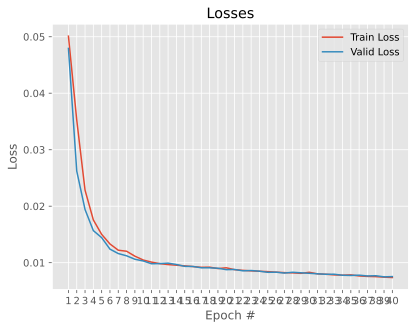

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')


epoch_ticks = range(1, epoch + 2)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

## Validation Accuracy

In [36]:
model.eval()
model.to(device)
num_correct = 0
num_samples = 0
predictions = []
answers = []

with torch.no_grad():
    for image, text, label in testloader:
        image, text, label =  image.to(device), text.to(device), label.to(device)
        probs = model.forward(image, text)

        _, prediction = probs.max(1)
        predictions.append(prediction)

        answer = torch.argmax(label, dim=1)
        answers.append(answer)

        num_correct += (prediction == answer).sum()
        num_samples += prediction.size(0)

    valid_acc = (f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    print(valid_acc)

    wandb.log({
    "Validation Accuracy": round(float(num_correct)/float(num_samples)*100, 2)})

Got 8830 / 9673 with accuracy 91.29


## Saving and Loading the model

In [43]:
import os
from pathlib import Path

project_path = '/content/drive/MyDrive/FSDL'  # Make sure this is your intended path
model_path = os.path.join(project_path, 'VGG19-Sbert-40')

model = VQA_v2(embedding_size=384, num_answers=13)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))  # or 'cpu' if you're not using CUDA
model.eval()



VQA_v2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [62]:
import torch
from urllib.request import urlopen
from PIL import Image
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_and_process_image_url(url):
    # Loads image from URL and converts to Tensor
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    im = Image.open(urlopen(url)).convert('RGB')
    im = transform(im)
    return im

url = "https://www.nicepng.com/png/detail/16-163438_circle-clipart-sky-blue-clip-art-blue-circle.png"
image = load_and_process_image_url(url)
image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

text = 'What shape is this?'
text = st_model.encode(text)
text = torch.tensor(text, dtype=torch.float).unsqueeze(0).to(device)  # Add batch dimension and send to device

model = VQA_v2(embedding_size = 384, num_answers = 13).to(device)
model.eval()

with torch.no_grad():  # Ensure no gradients are computed for this forward pass
    probs = model(image, text)
    answer_idx = torch.argmax(probs, dim=1)  # Get index of answer with highest probability
    answer_text = [all_answers[idx] for idx in answer_idx.cpu().numpy()]  # Convert index to answer text and ensure it's on CPU for NumPy compatibility
    print(answer_text)



['circle']
